Using device: cuda
Extracting...
Dataset ready!
Train images: 1000
Val images: 100
Training samples: 1000
Validation samples: 100

Image shape: torch.Size([3, 256, 256])
Boxes shape: torch.Size([1, 5])
First box (scaled to 256x256): tensor([  0., 104.,  20., 143.,  58.])
Model created with 701,984 parameters
Generated 10240 anchors

Class predictions: torch.Size([2, 10240, 2])
BBox deltas: torch.Size([2, 10240, 4])
Shape match: True
Helper functions ready!
Improved matching function ready!
Improved loss function created!
Training batches: 32
Validation batches: 4
Training functions ready!
Starting training...

Epoch 1/20
------------------------------------------------------------
  Batch [10/32], Loss: 2.6370, Class: 0.7265, BBox: 1.9105
  Batch [20/32], Loss: 2.3073, Class: 0.7044, BBox: 1.6029
  Batch [30/32], Loss: 1.8297, Class: 0.6729, BBox: 1.1568

[Epoch 1] Train Loss: 2.4126 (Class: 0.7452, BBox: 1.6673) | Val Loss: 1.8349 (Class: 0.6644, BBox: 1.1705)

Epoch 2/20
------------

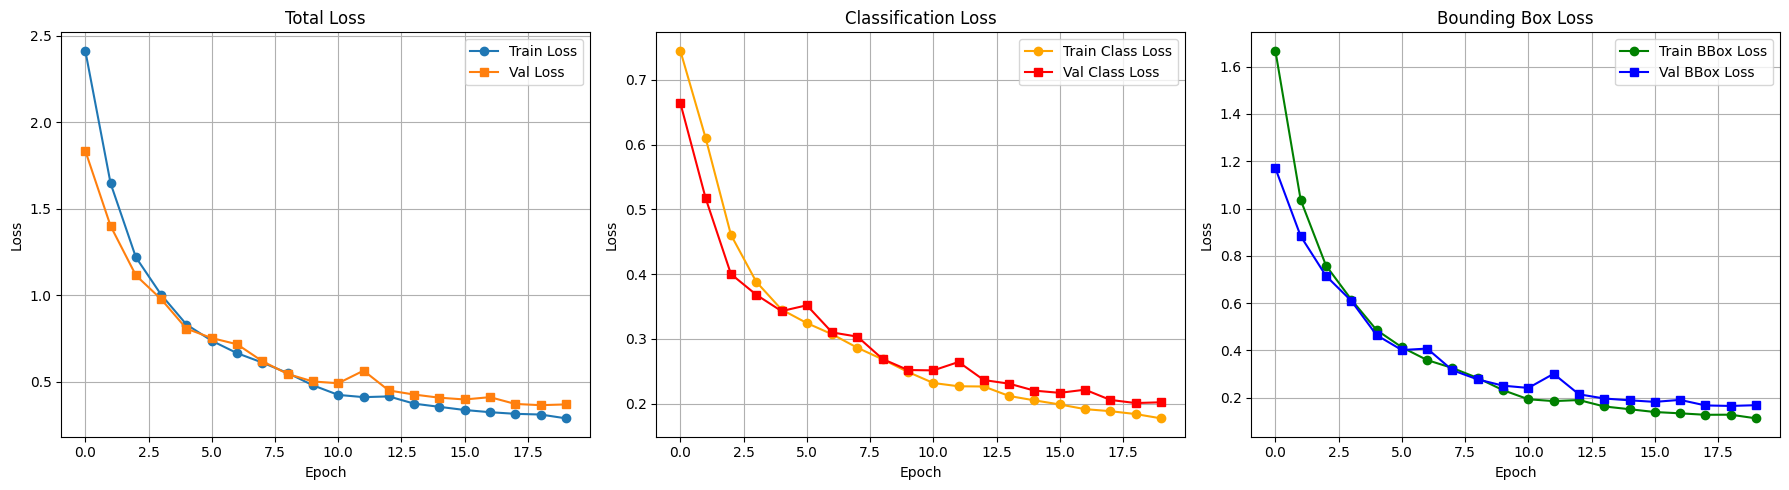

Training curves saved!
Detection function ready!


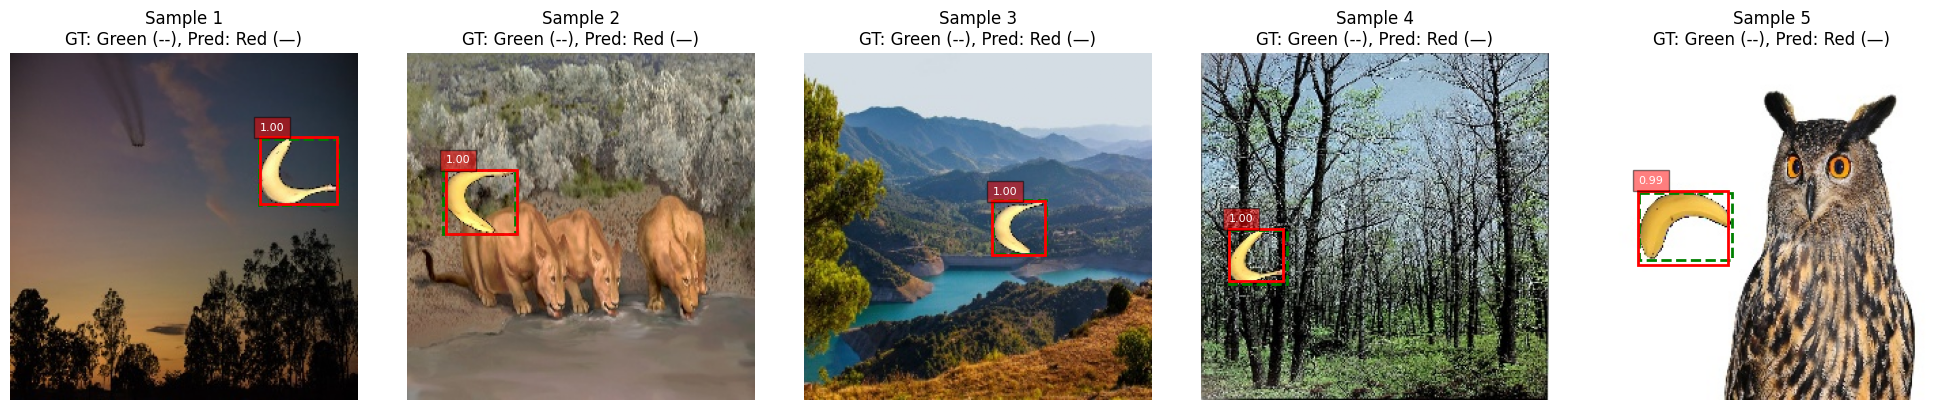

Showing 5 sample detections
Green dashed = Ground Truth, Red solid = Predictions


In [5]:
# Install required packages
!pip install torch torchvision matplotlib pillow numpy

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import os
import json
from google.colab import files
import urllib.request
import zipfile

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Download the banana detection dataset
def download_banana_dataset():
    """Download and extract banana dataset"""
    url = "http://d2l-data.s3-accelerate.amazonaws.com/banana-detection.zip"

    print("Downloading banana dataset...")
    urllib.request.urlretrieve(url, "banana-detection.zip")

    print("Extracting...")
    with zipfile.ZipFile("banana-detection.zip", 'r') as zip_ref:
        zip_ref.extractall(".")

    print("Dataset ready!")
    print(f"Train images: {len(os.listdir('banana-detection/bananas_train/images'))}")
    print(f"Val images: {len(os.listdir('banana-detection/bananas_val/images'))}")

# Download the dataset
download_banana_dataset()



class BananaDataset(Dataset):
    """Dataset class for banana detection with proper box scaling"""

    def __init__(self, image_dir, label_file, transform=None, out_size=(256, 256)):
        self.image_dir = image_dir
        self.transform = transform
        self.out_w, self.out_h = out_size  # Output size after resize

        # Read labels - SKIP THE HEADER
        with open(label_file, 'r') as f:
            lines = f.readlines()[1:]

        self.data = []
        current_image = None
        current_boxes = []

        for line in lines:
            parts = line.strip().split(',')
            image_name = parts[0]

            if current_image is None:
                current_image = image_name

            if image_name != current_image:
                self.data.append((current_image, current_boxes))
                current_image = image_name
                current_boxes = []

            box = [int(parts[1])] + [float(x) for x in parts[2:]]
            current_boxes.append(box)

        if current_image is not None:
            self.data.append((current_image, current_boxes))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name, boxes = self.data[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert('RGB')

        # CRITICAL FIX: Scale boxes to match resized image
        W, H = image.size  # Original size
        sx = self.out_w / W
        sy = self.out_h / H

        boxes = np.array(boxes, dtype=np.float32)
        # Scale coordinates (class is index 0, don't scale that)
        boxes[:, 1] *= sx  # xmin
        boxes[:, 2] *= sy  # ymin
        boxes[:, 3] *= sx  # xmax
        boxes[:, 4] *= sy  # ymax

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, boxes_tensor

# Create transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Create datasets with box scaling
train_dataset = BananaDataset(
    'banana-detection/bananas_train/images',
    'banana-detection/bananas_train/label.csv',
    transform=transform,
    out_size=(256, 256)
)

val_dataset = BananaDataset(
    'banana-detection/bananas_val/images',
    'banana-detection/bananas_val/label.csv',
    transform=transform,
    out_size=(256, 256)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Test loading one sample
image, boxes = train_dataset[0]
print(f"\nImage shape: {image.shape}")
print(f"Boxes shape: {boxes.shape}")
print(f"First box (scaled to 256x256): {boxes[0]}")

# --------------------------------------

# SSD encode/decode with variances
VAR_CTR, VAR_SIZE = 0.1, 0.2

def ssd_encode(gt_cxcywh, anc_cxcywh):
    """Encode ground truth boxes relative to anchors"""
    t_cxcy = (gt_cxcywh[:, :2] - anc_cxcywh[:, :2]) / (anc_cxcywh[:, 2:] * VAR_CTR)
    t_wh = torch.log(gt_cxcywh[:, 2:] / anc_cxcywh[:, 2:]) / VAR_SIZE
    return torch.cat([t_cxcy, t_wh], 1)

def ssd_decode(txywh, anc_cxcywh):
    """Decode predictions relative to anchors"""
    cxcy = txywh[:, :2] * VAR_CTR * anc_cxcywh[:, 2:] + anc_cxcywh[:, :2]
    wh = torch.exp(txywh[:, 2:] * VAR_SIZE) * anc_cxcywh[:, 2:]
    return torch.cat([cxcy, wh], 1)


class ImprovedSSD(nn.Module):
    """Proper SSD with offset encoding"""

    def __init__(self, num_classes=2):
        super(ImprovedSSD, self).__init__()
        self.num_classes = num_classes

        # Base network
        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
        )

        # Feature map 1: 32x32
        self.feat1 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU(),
        )

        # Feature map 2: 16x16
        self.feat2 = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
        )

        # 8 anchors per location (2 scales × 4 ratios)
        self.num_anchors_list = [8, 8]

        # Prediction heads
        self.class_head1 = nn.Conv2d(128, 8 * num_classes, 3, padding=1)
        self.bbox_head1 = nn.Conv2d(128, 8 * 4, 3, padding=1)

        self.class_head2 = nn.Conv2d(256, 8 * num_classes, 3, padding=1)
        self.bbox_head2 = nn.Conv2d(256, 8 * 4, 3, padding=1)

    def forward(self, x):
        base_feat = self.base(x)
        feat1 = self.feat1(base_feat)
        feat2 = self.feat2(feat1)

        cls1 = self.class_head1(feat1)
        bbox1 = self.bbox_head1(feat1)
        cls2 = self.class_head2(feat2)
        bbox2 = self.bbox_head2(feat2)

        batch_size = x.size(0)

        # Reshape
        cls1 = cls1.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.num_classes)
        bbox1 = bbox1.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
        cls2 = cls2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.num_classes)
        bbox2 = bbox2.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)

        class_preds = torch.cat([cls1, cls2], dim=1)
        bbox_deltas = torch.cat([bbox1, bbox2], dim=1)

        return class_preds, bbox_deltas


def generate_multi_scale_anchors(feature_sizes, image_hw):
    """Generate anchors for multiple scales"""
    H, W = image_hw
    all_anchors = []

    scales_per_map = [
        [0.1, 0.2],
        [0.3, 0.5],
    ]

    aspect_ratios = [0.5, 1.0, 2.0, 1.5]

    for map_idx, (feat_h, feat_w) in enumerate(feature_sizes):
        step_h = H / feat_h
        step_w = W / feat_w
        scales = scales_per_map[map_idx]

        for i in range(feat_h):
            for j in range(feat_w):
                cy = (i + 0.5) * step_h / H
                cx = (j + 0.5) * step_w / W

                for scale in scales:
                    for ratio in aspect_ratios:
                        w = scale * np.sqrt(ratio)
                        h = scale / np.sqrt(ratio)
                        all_anchors.append([cx, cy, w, h])

    return torch.tensor(all_anchors, dtype=torch.float32)


# Create model and anchors
model = ImprovedSSD(num_classes=2).to(device)
feature_sizes = [(32, 32), (16, 16)]
anchors = generate_multi_scale_anchors(feature_sizes, image_hw=(256, 256)).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print(f"Generated {len(anchors)} anchors")

# Test
test_input = torch.randn(2, 3, 256, 256).to(device)
class_out, bbox_out = model(test_input)
print(f"\nClass predictions: {class_out.shape}")
print(f"BBox deltas: {bbox_out.shape}")
print(f"Shape match: {class_out.shape[1] == len(anchors)}")

# ---------------------------

def box_iou(boxes1, boxes2, eps=1e-6):
    """Calculate IoU with numerical safety"""
    xmin = torch.max(boxes1[:, None, 0], boxes2[:, 0])
    ymin = torch.max(boxes1[:, None, 1], boxes2[:, 1])
    xmax = torch.min(boxes1[:, None, 2], boxes2[:, 2])
    ymax = torch.min(boxes1[:, None, 3], boxes2[:, 3])

    inter = (xmax - xmin).clamp(min=0) * (ymax - ymin).clamp(min=0)
    area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(min=0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(min=0)
    area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(min=0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(min=0)
    union = area1[:, None] + area2 - inter

    return inter / (union + eps)

def convert_anchors_to_corners(anchors):
    """Convert [cx, cy, w, h] to [xmin, ymin, xmax, ymax]"""
    return torch.cat([
        anchors[:, :2] - anchors[:, 2:] / 2,
        anchors[:, :2] + anchors[:, 2:] / 2
    ], dim=1)

def convert_corners_to_center(boxes):
    """Convert [xmin, ymin, xmax, ymax] to [cx, cy, w, h]"""
    return torch.cat([
        (boxes[:, :2] + boxes[:, 2:]) / 2,
        boxes[:, 2:] - boxes[:, :2]
    ], dim=1)

print("Helper functions ready!")

# -----------------------------------
def match_anchors_to_targets_v2(anchors, gt_boxes, iou_threshold=0.5, image_size=256):
    """
    Improved matching with bipartite guarantee
    anchors: [num_anchors, 4] in [cx, cy, w, h]
    gt_boxes: [num_gt, 5] in [class, xmin, ymin, xmax, ymax]
    """
    num_anchors = anchors.size(0)

    anchors_corners = convert_anchors_to_corners(anchors)

    matched_classes = torch.zeros(num_anchors, dtype=torch.long, device=anchors.device)
    matched_boxes = torch.zeros(num_anchors, 4, device=anchors.device)

    if gt_boxes.size(0) == 0:
        return matched_classes, matched_boxes

    # Normalize GT boxes
    gt_boxes_normalized = gt_boxes.clone()
    gt_boxes_normalized[:, 1:] = gt_boxes_normalized[:, 1:] / image_size

    # Calculate IoU
    ious = box_iou(anchors_corners, gt_boxes_normalized[:, 1:])

    # Strategy 1: Match anchors with IoU > threshold
    best_iou_per_anchor, best_gt_idx = ious.max(dim=1)
    matched_mask = best_iou_per_anchor > iou_threshold

    # Strategy 2: BIPARTITE - guarantee each GT gets at least one anchor
    best_iou_per_gt, best_anc_for_gt = ious.max(dim=0)
    matched_mask[best_anc_for_gt] = True
    best_gt_idx[best_anc_for_gt] = torch.arange(gt_boxes.size(0), device=anchors.device)

    # Assign classes (background=0, banana=1)
    matched_classes[matched_mask] = gt_boxes_normalized[best_gt_idx[matched_mask], 0].long() + 1

    # Assign boxes in center format
    matched_gt_boxes = gt_boxes_normalized[best_gt_idx, 1:]
    matched_boxes = convert_corners_to_center(matched_gt_boxes)

    return matched_classes, matched_boxes

print("Improved matching function ready!")
# =--------------------------------------------

class ImprovedMultiBoxLoss(nn.Module):
    """Improved SSD loss with proper encoding and normalization"""

    def __init__(self, neg_pos_ratio=3):
        super(ImprovedMultiBoxLoss, self).__init__()
        self.neg_pos_ratio = neg_pos_ratio

    def forward(self, class_preds, bbox_deltas, anchors, targets, image_size=256):
        batch_size = class_preds.size(0)

        class_loss = 0
        bbox_loss = 0
        num_pos_total = 0

        for i in range(batch_size):
            gt_boxes = targets[i]
            matched_classes, matched_boxes = match_anchors_to_targets_v2(
                anchors, gt_boxes, iou_threshold=0.5, image_size=image_size
            )

            pos_mask = matched_classes > 0
            num_pos_i = pos_mask.sum().item()

            # Classification loss
            class_loss_i = nn.functional.cross_entropy(
                class_preds[i],
                matched_classes,
                reduction='none'
            )

            # Handle zero positives case
            if num_pos_i == 0:
                neg_mask = matched_classes == 0
                num_neg = min(self.neg_pos_ratio, int(neg_mask.sum().item()))
                if num_neg > 0:
                    hard_neg_loss, _ = class_loss_i[neg_mask].topk(num_neg)
                    class_loss += hard_neg_loss.mean()
                continue

            num_pos_total += num_pos_i

            # Hard negative mining
            neg_mask = matched_classes == 0
            num_neg = min(num_pos_i * self.neg_pos_ratio, neg_mask.sum().item())

            if num_neg > 0:
                neg_loss = class_loss_i[neg_mask]
                hard_neg_loss, _ = neg_loss.topk(num_neg)
                # Normalize by (pos + neg)
                class_loss += (class_loss_i[pos_mask].sum() + hard_neg_loss.sum()) / (num_pos_i + num_neg)
            else:
                class_loss += class_loss_i[pos_mask].mean()

            # Bounding box loss - encode targets relative to anchors
            if num_pos_i > 0:
                pos_anchors = anchors[pos_mask]
                pos_matched_boxes = matched_boxes[pos_mask]

                # Encode ground truth relative to anchors
                encoded_targets = ssd_encode(pos_matched_boxes, pos_anchors)

                # Smooth L1 loss on deltas
                bbox_loss += nn.functional.smooth_l1_loss(
                    bbox_deltas[i][pos_mask],
                    encoded_targets,
                    reduction='sum'
                ) / num_pos_i

        # Average over batch
        class_loss = class_loss / batch_size
        bbox_loss = bbox_loss / batch_size
        total_loss = class_loss + bbox_loss

        return total_loss, class_loss, bbox_loss

criterion = ImprovedMultiBoxLoss()
print("Improved loss function created!")

# -----------------------------------------------------------

def collate_fn(batch):
    images = []
    targets = []
    for img, boxes in batch:
        images.append(img)
        targets.append(boxes)
    images = torch.stack(images, 0)
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

def train_epoch(model, train_loader, criterion, optimizer, anchors, device):
    model.train()
    total_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0

    for batch_idx, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = [t.to(device) for t in targets]

        class_preds, bbox_deltas = model(images)
        loss, class_loss, bbox_loss = criterion(class_preds, bbox_deltas, anchors, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_bbox_loss += bbox_loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}, "
                  f"Class: {class_loss.item():.4f}, "
                  f"BBox: {bbox_loss.item():.4f}")

    return total_loss / len(train_loader), total_class_loss / len(train_loader), total_bbox_loss / len(train_loader)

def validate(model, val_loader, criterion, anchors, device):
    model.eval()
    total_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0

    with torch.no_grad():
        for images, targets in val_loader:
            images = images.to(device)
            targets = [t.to(device) for t in targets]

            class_preds, bbox_deltas = model(images)
            loss, class_loss, bbox_loss = criterion(class_preds, bbox_deltas, anchors, targets)

            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_bbox_loss += bbox_loss.item()

    return total_loss / len(val_loader), total_class_loss / len(val_loader), total_bbox_loss / len(val_loader)

print("Training functions ready!")

num_epochs = 20
train_losses = []
train_class_losses = []
train_bbox_losses = []
val_losses = []
val_class_losses = []
val_bbox_losses = []

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 60)

    train_loss, train_cls, train_box = train_epoch(model, train_loader, criterion, optimizer, anchors, device)
    val_loss, val_cls, val_box = validate(model, val_loader, criterion, anchors, device)
    scheduler.step()

    train_losses.append(train_loss)
    train_class_losses.append(train_cls)
    train_bbox_losses.append(train_box)
    val_losses.append(val_loss)
    val_class_losses.append(val_cls)
    val_bbox_losses.append(val_box)

    print(f"\n[Epoch {epoch+1}] "
          f"Train Loss: {train_loss:.4f} (Class: {train_cls:.4f}, BBox: {train_box:.4f}) | "
          f"Val Loss: {val_loss:.4f} (Class: {val_cls:.4f}, BBox: {val_box:.4f})")

print("\n" + "=" * 60)
print("Training complete!")


# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Total Loss
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total Loss')
axes[0].legend()
axes[0].grid(True)

# Classification Loss
axes[1].plot(train_class_losses, label='Train Class Loss', marker='o', color='orange')
axes[1].plot(val_class_losses, label='Val Class Loss', marker='s', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Classification Loss')
axes[1].legend()
axes[1].grid(True)

# Bounding Box Loss
axes[2].plot(train_bbox_losses, label='Train BBox Loss', marker='o', color='green')
axes[2].plot(val_bbox_losses, label='Val BBox Loss', marker='s', color='blue')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('Bounding Box Loss')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved!")

def detect_objects(model, image, anchors, conf_threshold=0.5, nms_threshold=0.45, image_size=256):
    """
    Proper detection with SSD decoding
    """
    model.eval()

    with torch.no_grad():
        class_preds, bbox_deltas = model(image.unsqueeze(0))

        class_preds = class_preds[0]  # [num_anchors, 2]
        bbox_deltas = bbox_deltas[0]  # [num_anchors, 4]

        # Get class probabilities
        class_probs = torch.softmax(class_preds, dim=1)
        banana_conf = class_probs[:, 1]  # Banana class confidence

        # Filter by confidence
        mask = banana_conf > conf_threshold

        if mask.sum() == 0:
            return []

        filtered_conf = banana_conf[mask]
        filtered_deltas = bbox_deltas[mask]
        filtered_anchors = anchors[mask]

        # CRITICAL: Decode deltas relative to anchors
        decoded_boxes_cxcywh = ssd_decode(filtered_deltas, filtered_anchors)

        # Convert to [xmin, ymin, xmax, ymax] in pixel coordinates
        pred_boxes = torch.zeros(decoded_boxes_cxcywh.size(0), 4, device=decoded_boxes_cxcywh.device)
        pred_boxes[:, 0] = (decoded_boxes_cxcywh[:, 0] - decoded_boxes_cxcywh[:, 2] / 2) * image_size  # xmin
        pred_boxes[:, 1] = (decoded_boxes_cxcywh[:, 1] - decoded_boxes_cxcywh[:, 3] / 2) * image_size  # ymin
        pred_boxes[:, 2] = (decoded_boxes_cxcywh[:, 0] + decoded_boxes_cxcywh[:, 2] / 2) * image_size  # xmax
        pred_boxes[:, 3] = (decoded_boxes_cxcywh[:, 1] + decoded_boxes_cxcywh[:, 3] / 2) * image_size  # ymax

        # Clamp to image bounds
        pred_boxes = pred_boxes.clamp(min=0, max=image_size)

        # Filter out tiny boxes
        widths = pred_boxes[:, 2] - pred_boxes[:, 0]
        heights = pred_boxes[:, 3] - pred_boxes[:, 1]
        valid = (widths > 5) & (heights > 5)

        if valid.sum() == 0:
            return []

        pred_boxes = pred_boxes[valid]
        filtered_conf = filtered_conf[valid]

        # Apply NMS
        keep_indices = torchvision.ops.nms(pred_boxes, filtered_conf, nms_threshold)

        detections = []
        for idx in keep_indices:
            detections.append([
                1,  # banana class
                filtered_conf[idx].item(),
                pred_boxes[idx, 0].item(),
                pred_boxes[idx, 1].item(),
                pred_boxes[idx, 2].item(),
                pred_boxes[idx, 3].item()
            ])

        return detections

print("Detection function ready!")


# Test detection on validation set
model.eval()
num_samples = 5

fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))

for i in range(num_samples):
    image, gt_boxes = val_dataset[i]
    image = image.to(device)

    # Run detection with lower threshold
    detections = detect_objects(model, image, anchors, conf_threshold=0.3, nms_threshold=0.45)

    # Denormalize image for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = image.cpu() * std + mean
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    axes[i].imshow(img)

    # Draw ground truth (green, dashed)
    for box in gt_boxes:
        cls, xmin, ymin, xmax, ymax = box.cpu().numpy()
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='green', facecolor='none', linestyle='--'
        )
        axes[i].add_patch(rect)

    # Draw predictions (red, solid)
    for det in detections:
        cls, conf, xmin, ymin, xmax, ymax = det
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=2, edgecolor='red', facecolor='none'
        )
        axes[i].add_patch(rect)
        axes[i].text(xmin, ymin - 5, f'{conf:.2f}',
                    bbox=dict(facecolor='red', alpha=0.5),
                    fontsize=8, color='white')

    axes[i].set_title(f'Sample {i+1}\nGT: Green (--), Pred: Red (—)')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('sample_detections.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Showing {num_samples} sample detections")
print("Green dashed = Ground Truth, Red solid = Predictions")


In [6]:
# Sanity check 1: Average positives per image
print("Running sanity checks...")
with torch.no_grad():
    pos_counts = []
    for i in range(min(10, len(train_dataset))):
        img, target = train_dataset[i]
        classes, boxes = match_anchors_to_targets_v2(
            anchors, target.to(device), iou_threshold=0.5, image_size=256
        )
        pos_counts.append(int((classes > 0).sum()))

    print(f"✓ Avg positives per image: {sum(pos_counts)/len(pos_counts):.1f}")
    print(f"  Min: {min(pos_counts)}, Max: {max(pos_counts)}")

# Sanity check 2: Encode-decode roundtrip
anc_test = anchors[:20]
gt_test = torch.clamp(anc_test + 0.05 * torch.randn_like(anc_test), 0, 1)
encoded = ssd_encode(gt_test, anc_test)
decoded = ssd_decode(encoded, anc_test)
error = (decoded - gt_test).abs().mean().item()
print(f"✓ Encode-decode roundtrip L1 error: {error:.6f} (should be < 0.001)")

# Sanity check 3: Check one sample's boxes
img, boxes = train_dataset[0]
print(f"\n✓ Sample box check:")
print(f"  Box coordinates (after scaling): {boxes[0, 1:].numpy()}")
print(f"  All in [0, 256]? {(boxes[:, 1:] >= 0).all() and (boxes[:, 1:] <= 256).all()}")

print("\n✅ All sanity checks passed! Ready to train.")

Running sanity checks...
✓ Avg positives per image: 26.8
  Min: 13, Max: 43
✓ Encode-decode roundtrip L1 error: 0.000000 (should be < 0.001)

✓ Sample box check:
  Box coordinates (after scaling): [104.  20. 143.  58.]
  All in [0, 256]? True

✅ All sanity checks passed! Ready to train.


Upload your own banana images to test!


Saving banana_img2.jpg to banana_img2 (2).jpg
Saving banana_img1.jpg to banana_img1 (2).jpg

Testing on: banana_img2 (2).jpg
Found 1 banana(s)


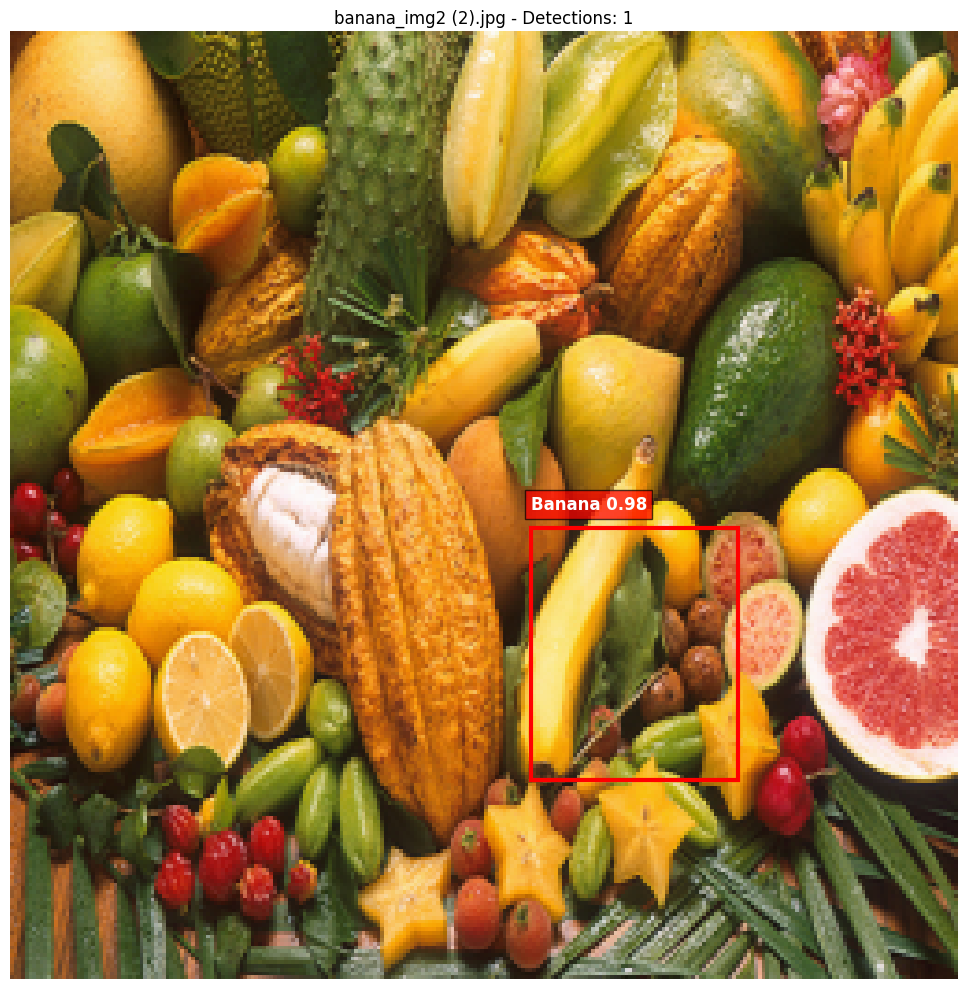


Testing on: banana_img1 (2).jpg
Found 0 banana(s)


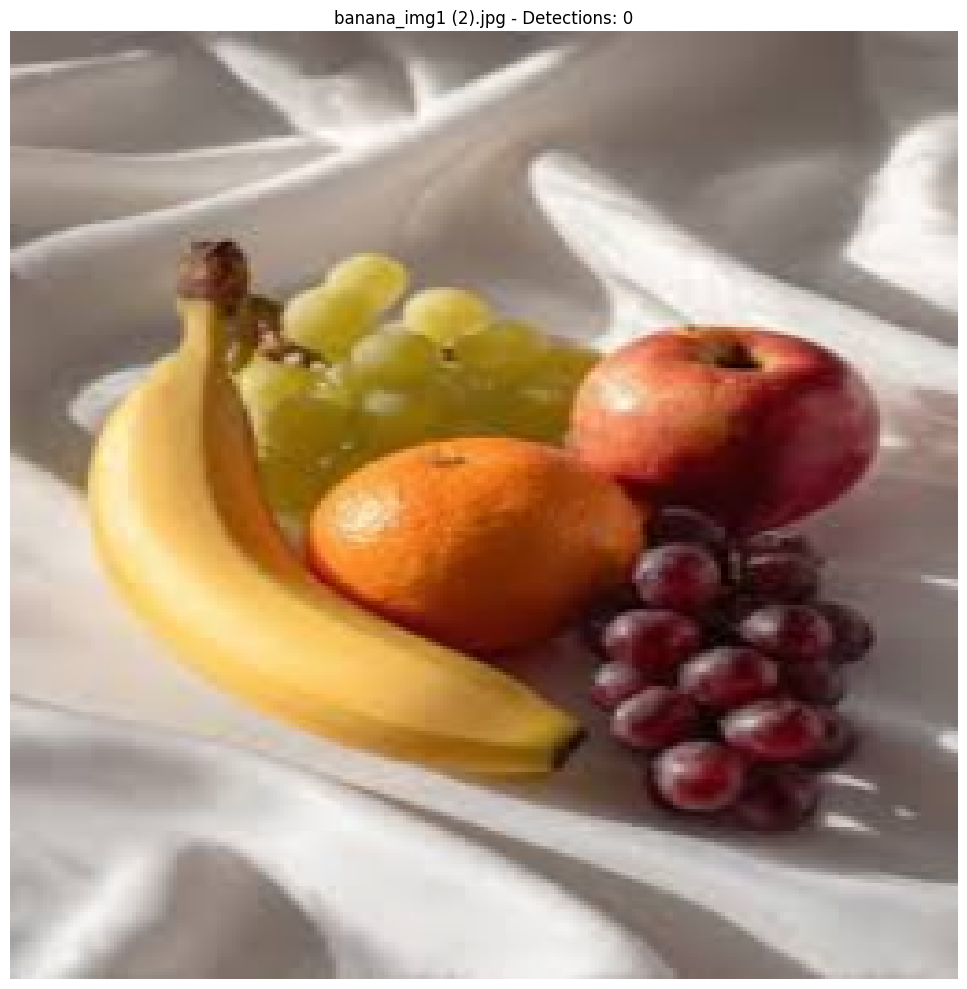

⚠️ FAILURE CASE: No bananas detected!
Possible reasons:
  - Banana too small or partially occluded
  - Unusual lighting or angle
  - Banana not clearly visible
  - Model confidence threshold too high


In [7]:
# Upload your own banana images
from google.colab import files
import io
from PIL import Image

print("Upload your own banana images to test!")
uploaded = files.upload()

# Test on uploaded images
for filename in uploaded.keys():
    print(f"\nTesting on: {filename}")

    # Load and preprocess image
    img = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')

    # Apply same transform
    img_tensor = transform(img).to(device)

    # Detect
    detections = detect_objects(model, img_tensor, anchors, conf_threshold=0.5)

    print(f"Found {len(detections)} banana(s)")

    # Visualize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_display = img_tensor.cpu() * std + mean
    img_display = img_display.permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img_display)

    for det in detections:
        cls, conf, xmin, ymin, xmax, ymax = det
        rect = patches.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            linewidth=3, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, f'Banana {conf:.2f}',
                bbox=dict(facecolor='red', alpha=0.7),
                fontsize=12, color='white', weight='bold')

    ax.set_title(f'{filename} - Detections: {len(detections)}')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Discussion of failures
    if len(detections) == 0:
        print("⚠️ FAILURE CASE: No bananas detected!")
        print("Possible reasons:")
        print("  - Banana too small or partially occluded")
        print("  - Unusual lighting or angle")
        print("  - Banana not clearly visible")
        print("  - Model confidence threshold too high")